# LOS prediction analysis

In [120]:
import numpy as np
import pandas as pd
import os
import pickle
import time

In [121]:
from tensorflow.contrib.keras.api.keras.preprocessing import sequence
from tensorflow.contrib.keras.api.keras.layers import Input, Embedding, GRU, Dense, LSTM #, Activation
from tensorflow.contrib.keras.api.keras.models import Model
from tensorflow.contrib.keras.python.keras.layers import Bidirectional, TimeDistributed
from sklearn.model_selection import train_test_split

In [122]:
# Import data
data = np.load('./data/all_data.npy')
target = np.load('./data/targets.npy')

# pad the data to max length with zero arrays
max_length = max([i.shape[0] for i in data])
padded_data = []
padded_target = []
for i in range(len(data)):
    item_arr = []
    target_arr = []
    arr_length = len(data[i])
    for j in range(len(data[i])):
        item_arr.append(data[i][j])
        target_arr.append(target[i][j])
    for i in range(max_length - arr_length):
        #pad the arrays
        item_arr.append(np.zeros(shape=(10,)))
        target_arr.append(np.asarray([0]*11+[1]))
    #conv to np arrays
    item_arr = np.array(item_arr)
    target_arr= np.array(target_arr)
    #add to padded lists
    padded_data.append(item_arr)
    padded_target.append(target_arr)
padded_data = np.array(padded_data)
padded_target = np.array(padded_target)

train_test_split_ratio = 0.1
padded_data = np.nan_to_num(padded_data, 0)
X_train, X_test, y_train, y_test = train_test_split(padded_data, padded_target, test_size = train_test_split_ratio)

In [123]:
# Configs
TARGET_SIZE = 12 # Number of different buckets for LOS
BATCH_SIZE = 20
RNN_HIDDEN_SIZE = max_length # ?+1 for capitalisation flag

## Build RNN model

In [124]:
input_layer = Input(shape = (max_length,10), name = 'input_embeddings')
x = input_layer
#x = Dense(50, name = 'input_widener')(input_layer)
x = Bidirectional (LSTM(RNN_HIDDEN_SIZE, return_sequences=True, activation = 'relu',dropout=0.1), merge_mode='concat')(x)
#x = Bidirectional (LSTM(RNN_HIDDEN_SIZE, return_sequences=False, activation = 'relu',dropout=0.1), merge_mode='concat')(x)
output_layer = TimeDistributed(Dense(TARGET_SIZE, activation='softmax'
                                     , name = 'output_dense'
                                     ,input_shape=(BATCH_SIZE, max_length, RNN_HIDDEN_SIZE*2)
                                    )\
                              )(x)
model = Model(inputs = [input_layer], outputs= [output_layer])

In [125]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_embeddings (InputLayer (None, 21, 10)            0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, None, 42)          5376      
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 12)          516       
Total params: 5,892
Trainable params: 5,892
Non-trainable params: 0
_________________________________________________________________


In [126]:
# try using different optimizers and different optimizer configs
from keras import metrics
import keras.backend as K

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=5,
          validation_data=(X_test, y_test)
         )
score, acc = model.evaluate(X_test, y_test,
                            batch_size=BATCH_SIZE)
print('Test score:', score)
print('Test accuracy:', acc)
#print('Test Top 5 accuracy:', top_k_acc)

Train...
Train on 6316 samples, validate on 702 samples
Epoch 1/5
6316/6316 [==============================] - 20s - loss: 0.7188 - acc: 0.8338 - val_loss: 0.1648 - val_acc: 0.9281
Epoch 2/5
6316/6316 [==============================] - 17s - loss: 0.1442 - acc: 0.9345 - val_loss: 0.1096 - val_acc: 0.9404
Epoch 3/5
6316/6316 [==============================] - 18s - loss: 0.1121 - acc: 0.9439 - val_loss: 0.0943 - val_acc: 0.9493
Epoch 4/5
6316/6316 [==============================] - 18s - loss: 0.0988 - acc: 0.9487 - val_loss: 0.0862 - val_acc: 0.9529
Epoch 5/5
700/702 [============================>.] - ETA: 0sTest score: 0.0975478933408
Test accuracy: 0.951159944222


In [143]:
test_batch = np.array(X_test)
preds = model.predict(test_batch)

In [150]:
y_true = []
y_pred = []
for i in range(len(y_test)):
    for j in range(len(y_test[i])):
        mypred = preds[i][j].argmax()
        myact = y_test[i][j].argmax()
        if myact != 11:
            y_true.append(myact)
            y_pred.append(mypred)
            

In [151]:
from sklearn.metrics import classification_report, confusion_matrix

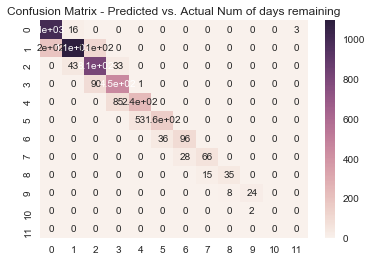

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
cfn_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(cfn_mat, annot=True)
plt.title('Confusion Matrix - Predicted vs. Actual Num of days remaining')
plt.show()
plt.savefig('./img/confusion_matrix.jpg')

In [160]:
print (classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.84      0.98      0.90      1020
          1       0.95      0.78      0.86      1401
          2       0.80      0.91      0.85       889
          3       0.79      0.83      0.81       543
          4       0.82      0.74      0.77       324
          5       0.81      0.75      0.78       208
          6       0.77      0.73      0.75       132
          7       0.81      0.70      0.75        94
          8       0.81      0.70      0.75        50
          9       0.92      0.75      0.83        32
         10       0.00      0.00      0.00         2
         11       0.00      0.00      0.00         0

avg / total       0.85      0.85      0.85      4695



/Users/adarsh/anaconda/envs/tfkeras/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/adarsh/anaconda/envs/tfkeras/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
